In [3]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob
from skimage.util import montage as montage2d

In [22]:
all_images=glob(os.path.join(r"D:\Spring_2023\Statistical Machine Learning\3d_data\archive",'3d_images','IMG_*'))


In [23]:
DS_FACT = 8 # downscale
def read_all_slices(in_paths, rescale = True):
    cur_vol = np.expand_dims(np.concatenate([nib.load(c_path).get_fdata()[:, ::DS_FACT, ::DS_FACT] 
                                          for c_path in in_paths], 0), -1)
    if rescale:
        return (cur_vol.astype(np.float32) + 500)/2000.0
    else:
        return cur_vol/255.0
    
    
def read_both(in_paths):
    in_vol = read_all_slices(in_paths)
    in_mask = read_all_slices(map(lambda x: x.replace('IMG_', 'MASK_'), in_paths), rescale = False)
    return in_vol, in_mask


def montage_nd(in_img):
    if len(in_img.shape)>3:
        return montage2d(np.stack([montage_nd(x_slice) for x_slice in in_img],0))
    elif len(in_img.shape)==3:
        return montage2d(in_img)
    else:
        warn('Input less than 3d image, returning original', RuntimeWarning)
        return in_img

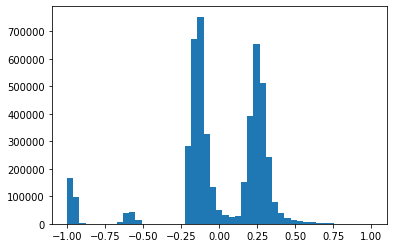

In [24]:

all_vol, all_mask = read_both(all_images)

plt.hist(all_vol.ravel(), np.linspace(-1, 1, 50));

(4, 32, 64, 64, 1) (4, 32, 64, 64, 1)


Text(0.5, 1.0, 'Out Batch')

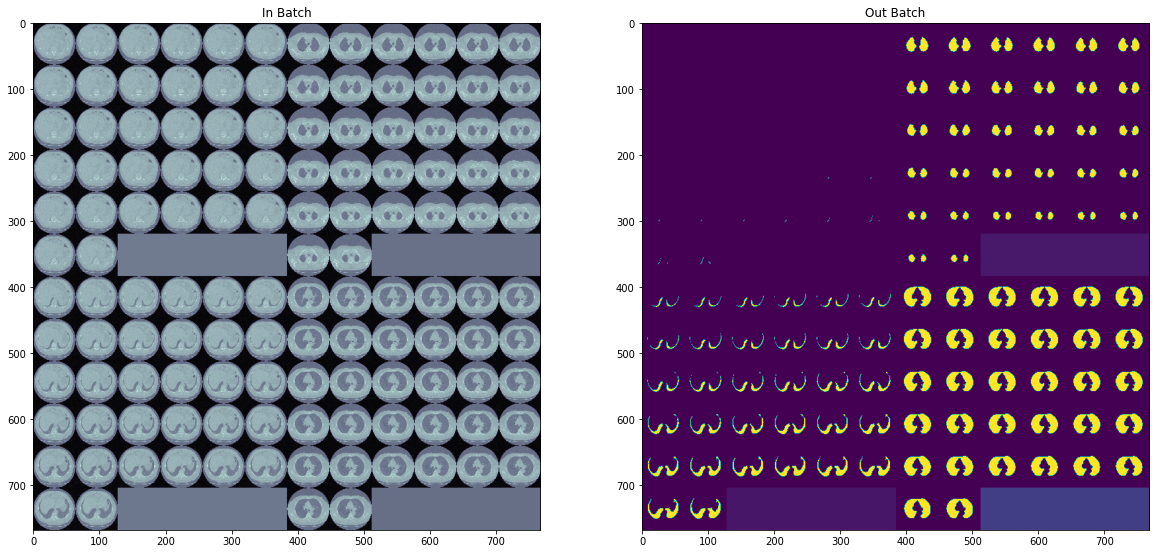

In [113]:
def gen_chunk(in_img, in_mask, slice_count = 32, batch_size = 4):
    while True:
        img_batch = []
        mask_batch = []
        for _ in range(batch_size):
            s_idx = np.random.choice(range(in_img.shape[0]-slice_count))
            img_batch += [in_img[s_idx:(s_idx+slice_count)]]
            mask_batch += [in_mask[s_idx:(s_idx+slice_count)]]
        yield np.stack(img_batch, 0), np.stack(mask_batch, 0)
        
        
# training we use larger batch sizes with fewer slices
all_gen = gen_chunk(all_vol, all_mask)
x_out, y_out = next(all_gen)
print(x_out.shape, y_out.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_nd(x_out[...,0]), cmap = 'bone')
ax1.set_title('In Batch')
ax2.imshow(montage_nd(y_out[...,0]))
ax2.set_title('Out Batch')

In [42]:
(next(all_gen)[0]).shape

(16, 4, 64, 64, 1)

In [57]:
def read_all_slices(in_paths, rescale = True):
    cur_vol = np.expand_dims(np.concatenate([nib.load(c_path).get_fdata()[:, ::DS_FACT, ::DS_FACT] 
                                          for c_path in in_paths], 0), -1)
    if rescale:
        return (cur_vol.astype(np.float32) + 500)/2000.0
    else:
        return cur_vol/255.0

In [64]:
test = [all_images[0]][0]

In [68]:
nib.load(test).get_fdata().shape

(325, 512, 512)

In [72]:
nib.load(test).get_fdata()[:, ::8, ::8].shape

(325, 64, 64)

In [78]:
np.concatenate(nib.load(test).get_fdata()[:, ::8, ::8], 0).shape

(20800, 64)

In [84]:
np.expand_dims(np.concatenate(nib.load(test).get_fdata()[:, ::8, ::8], 0), -1).shape

(20800, 64, 1)

In [111]:
list(map(lambda x: x.replace('IMG_', 'MASK_'), [test]))

['D:\\Spring_2023\\Statistical Machine Learning\\3d_data\\archive\\3d_images\\MASK_0002.nii.gz']

In [119]:
img_batch = []
in_img = np.expand_dims(np.concatenate(nib.load(test).get_fdata()[:, ::8, ::8], 0), -1)
slice_count = 32
for _ in range(4):
    s_idx = np.random.choice(range(in_img.shape[0]-slice_count))
    print(s_idx)
    img_batch += [in_img[s_idx:(s_idx+slice_count)]]
yield np.stack(img_batch, 0)

13399
18438
5207
13810


SyntaxError: 'yield' outside function (<ipython-input-119-cdd802577316>, line 8)